## Imports

In [1]:
import os
import random
import shap
import dice_ml
import joblib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor

shap.initjs()

c:\Users\User\Documents\WQF7009 - xAI\WQF7009-AA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [2]:
OUTPUT_DIR = "outputs/"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models/")
DATA_SPLITS = os.path.join(OUTPUT_DIR, "splits/")

GLOBAL_SEED = 63

In [3]:
def set_global_seed():
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

set_global_seed()

## Load Data and Model

Using the best model found from previous section—Catboost

In [4]:
model_study = joblib.load(os.path.join(MODEL_DIR, "catboost_regressor.joblib"))

X_train = pd.read_csv(os.path.join(DATA_SPLITS,'X_train.csv'))
X_test = pd.read_csv(os.path.join(DATA_SPLITS, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(DATA_SPLITS, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(DATA_SPLITS, 'y_test.csv'))

In [ ]:
best_params = model_study.best_params_

best_model = CatBoostRegressor(**best_params, logging_level='Silent')

In [6]:
best_model.fit(X_train, y_train)

## Feature Importance Explanation

Using SHAP

In [37]:
load_explainer = shap.Explainer(best_model)
shap_values = load_explainer(X_test)

### Plotting SHAP

1. Summary Plots (Global Importance)

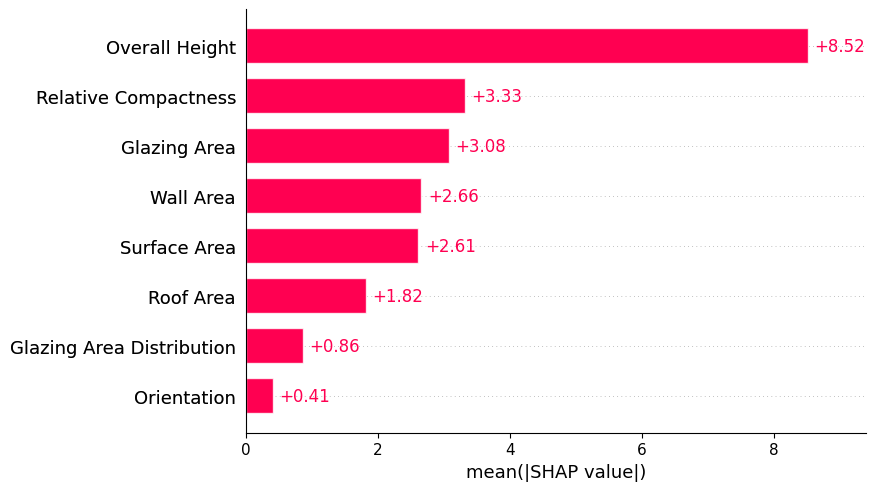

In [38]:
shap.plots.bar(shap_values)

2. Beeswarm plot (Global Importance)

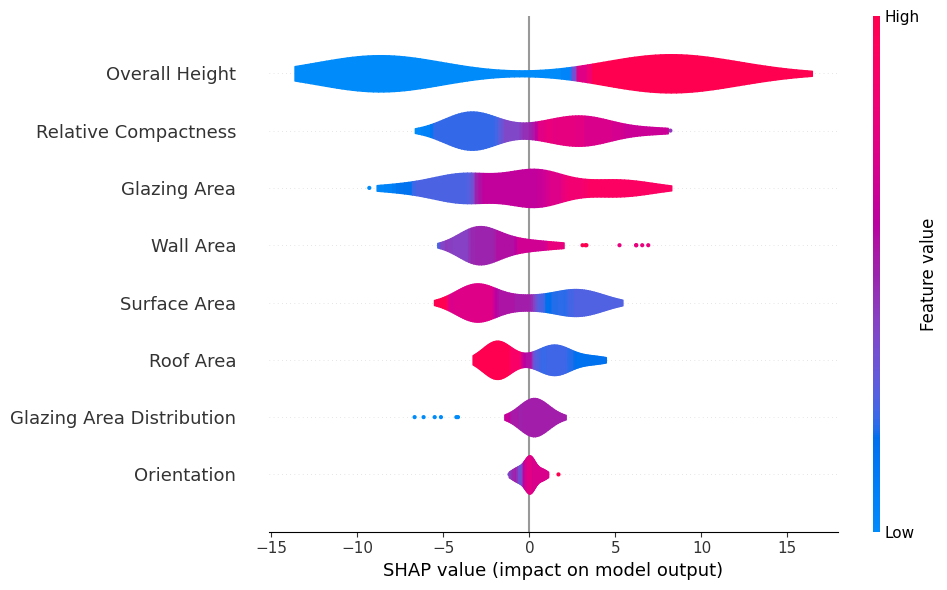

In [39]:
shap.plots.violin(shap_values, show=False)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

3. Waterfall plot (Local Importance)

In [40]:
rng = np.random.default_rng()
random_index = rng.integers(low=0, high=X_test.shape[0])

In [62]:
random_index

np.int64(10)

In [58]:
X_test.iloc[random_index]

Relative Compactness           0.9
Surface Area                 563.5
Wall Area                    318.5
Roof Area                    122.5
Overall Height                 7.0
Orientation                    3.0
Glazing Area                   0.1
Glazing Area Distribution      2.0
Name: 10, dtype: float64

In [42]:
y_test.iloc[random_index]

Combined Load    59.12
Name: 10, dtype: float64

In [46]:
type(X_test.iloc[random_index])

pandas.core.series.Series

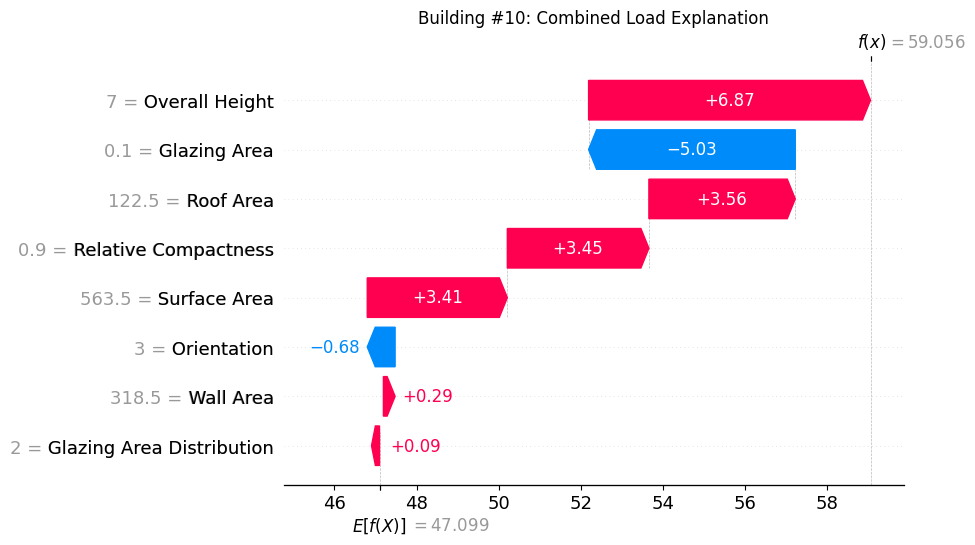

In [61]:
shap_values_instance = load_explainer.shap_values(pd.DataFrame([X_test.iloc[random_index].to_dict()]))

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_instance[0],
        base_values=load_explainer.expected_value,
        data=X_test.iloc[random_index].values,
        feature_names=X_test.columns.to_list()
    ),
    show=False
)
plt.title(f"Building #{random_index}: Combined Load Explanation")
plt.show()

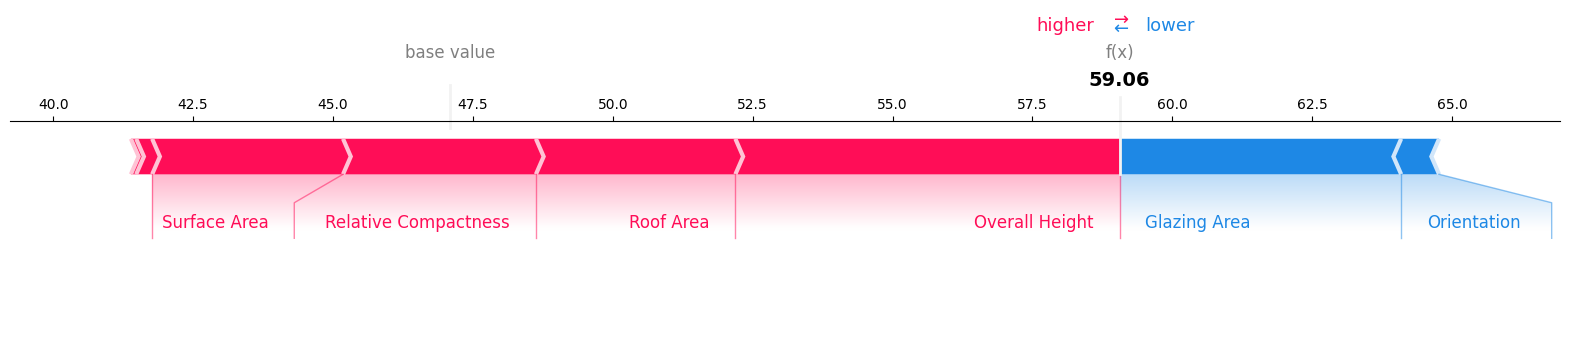

In [71]:
shap.plots.force(load_explainer.expected_value, shap_values_instance[0], feature_names=X_train.columns, show=False, matplotlib=True)
plt.show()

## Counterfactual Explanation

Using DiCE for single aggregated target

Create DiCE explainer

In [72]:
combined_df = pd.concat([X_train, y_train], axis=1)
continuous_features = X_train.columns.to_list()

In [73]:
dice_data = dice_ml.Data(
    dataframe=combined_df,
    continuous_features=continuous_features,
    outcome_name='Combined Load'
)

dice_model = dice_ml.Model(model=best_model, backend='sklearn', model_type='regressor')
dice_explainer = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method='random')

In [74]:
# Currently the total load of the previous building:
X_test.loc[random_index], y_test.loc[random_index]

(Relative Compactness           0.9
 Surface Area                 563.5
 Wall Area                    318.5
 Roof Area                    122.5
 Overall Height                 7.0
 Orientation                    3.0
 Glazing Area                   0.1
 Glazing Area Distribution      2.0
 Name: 10, dtype: float64,
 Combined Load    59.12
 Name: 10, dtype: float64)

In [75]:
query_instance = X_test.loc[random_index].to_frame().T

counterfactual = dice_explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_range=[35, 45]
)

100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


In [76]:
query_instance

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
10,0.9,563.5,318.5,122.5,7.0,3.0,0.1,2.0


In [77]:
counterfactual.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 59.0)


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,0.9,563.5,318.5,122.5,7.0,3.0,0.1,2.0,59.0



Diverse Counterfactual set (new outcome: [35, 45])


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,-,801.1,-,-,4.4,-,-,-,42.020145416259766
1,0.69,-,-,-,4.7,-,-,-,37.776344299316406
2,-,-,301.1,-,4.9,-,-,-,44.96046829223633
3,0.86,-,-,-,4.8,-,-,-,44.571128845214844
4,-,-,-,186.9,5.1,-,-,-,42.41590881347656


In [80]:
features_change = X_train.columns
features_change = features_change.drop('Overall Height')
features_change = features_change.to_list()
features_change

['Relative Compactness',
 'Surface Area',
 'Wall Area',
 'Roof Area',
 'Orientation',
 'Glazing Area',
 'Glazing Area Distribution']

In [81]:
counterfactual = dice_explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_range=[35, 45],
    features_to_vary=features_change
)

100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


In [82]:
counterfactual.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 59.0)


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,0.9,563.5,318.5,122.5,7.0,3.0,0.1,2.0,59.0



Diverse Counterfactual set (new outcome: [35, 45])


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,0.63,698.6,-,212.9,-,-,0.0,-,42.92533874511719
1,0.94,-,254.3,211.0,-,-,-,0.0,43.48805236816406
2,-,784.3,300.5,-,-,-,0.0,0.0,41.39236068725586
3,0.67,760.8,-,-,-,2.0,-,0.0,44.936031341552734
4,0.84,-,296.1,-,-,4.0,-,0.0,43.75069046020508
